<a href="https://colab.research.google.com/github/gagyeomkim/Deep-Learning-Paper-Review-and-Practice/blob/main/code_practice/Attention/Seq2Seq(Attention).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Luong의 General Version의 Attention 구현
- code by: https://github.com/graykode/nlp-tutorial

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]   # 배치 차원때문에, 대괄호 2개 써서 묶어줌

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

# model
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1) # enc_inputs: [max_len(=n_step; time_step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1) # dec_inputs: [max_len(=n_step; time step), batch_size(=1), n_class]

        # enc_outputs: [max_len(=n_step), batch_size, num_direction(=1) * n_hidden]
        # enc_hidden: [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden =enc_hidden
        n_step = len(dec_inputs)
        model = torch.empty([n_step, 1, n_class])   # 1은 batch 크기

        # -- Decoder --
        for i in range(n_step): # each time step
            # dec_inputs[i]: [batch_size, n_class]
            # dec_output: [max_len(=n_step=1),batch_size(=1),num_directions(=1)*n_hidden]
            # hidden: [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
            attn_weights = self.get_att_weight(dec_output, enc_outputs) # attn_weights: [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().detach().numpy())

            # matrix-matrix product of matrices: [1,1,n_step] x [batch_size(학습데이터가 1개였으므로, 1), n_step, n_hidden] = [1, 1, n_hidden]
            context = attn_weights.bmm(enc_outputs.transpose(0,1))

            # --- concatenate ---
            dec_output = dec_output.squeeze(0)  # [batch_size(=1), num_direcitons(=1) * n_hidden]
            context = context.squeeze(1)    # [1, num_directions(=1) * n_hidden]
            # torch.cat((dec_output, context), 1): [1, n_hidden * 2]
            model[i] = self.out(torch.cat((dec_output, context), 1))    # model[i]: [1, n_class] <- n_step개 만큼 채워 넣음

        # make model shape [n_step, n_class]
        # model: [n_step, 1, n_class]
        return model.transpose(0, 1).squeeze(0), trained_attn


    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        """
        dec_output: [max_len(=n_step=1),batch_size(=1),num_directions(=1) * n_hidden]
        enc_outputs: [max_len(=n_step), batch_size, num_direction(=1) * n_hidden]
        """
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)   # attn_scores: [n_step]

        for i in range(n_step): # encoder의 각 time step 별 output과의 score 구함
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)    # [1, 1, n_step]

    def get_att_score(self, dec_output, enc_output):
        """
        dec_output: [max_len(=n_step=1),batch_size(=1),num_directions(=1) * n_hidden] = [1, 1, n_hidden]
        enc_output: [batch_size, num_directions(=1)*n_hidden] = [batch_size, n_hidden]
        """
        # score: [batch_size, n_hidden]
        score = self.attn(enc_output)
        return torch.dot(dec_output.view(-1), score.view(-1))    # inner product make scalar value



if __name__=="__main__":
    n_step = 5  # number of cells(=number of Step)
    n_hidden = 128  # number of hidden units in one cell

    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w:i for i,w in enumerate(word_list)}   # word2index
    number_dict = {i:w for i, w in enumerate(word_list)}    # index2word
    n_class = len(word_dict)    # vocabulary

    # hidden: [num_layers(=1)*num_directions(=1), batch_size, n_hidden]
    hidden = torch.zeros(1, 1, n_hidden)
    input_batch, output_batch, target_batch = make_batch()

    model = Attention()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    for epoch in range(2000):
        optimizer.zero_grad()
        output, _ = model(input_batch, hidden, output_batch)

        loss = criterion(output, target_batch.squeeze(0))
        if (epoch + 1) % 400 == 0:
            print(f'Epoch: {epoch+1:#04d} cost: {loss:.6f}')

        loss.backward()
        optimizer.step()

    # Test
    test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
    test_batch = torch.FloatTensor(test_batch)
    predict, trained_attn = model(input_batch, hidden, test_batch)
    predict = torch.argmax(predict, dim=1)
    print(sentences[0],'->', [number_dict[n.item()] for n in predict.squeeze()])

/tmp/ipython-input-1566663511.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/tmp/ipython-input-1566663511.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_scores).view(1, 1, -1)    # [1, 1, n_step]


Epoch: 0400 cost: 0.000463
Epoch: 0800 cost: 0.000149
Epoch: 1200 cost: 0.000074
Epoch: 1600 cost: 0.000043
Epoch: 2000 cost: 0.000028
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


- `len()`: 0번째 차원의 크기 반환

/tmp/ipython-input-2673449293.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
/tmp/ipython-input-2673449293.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})


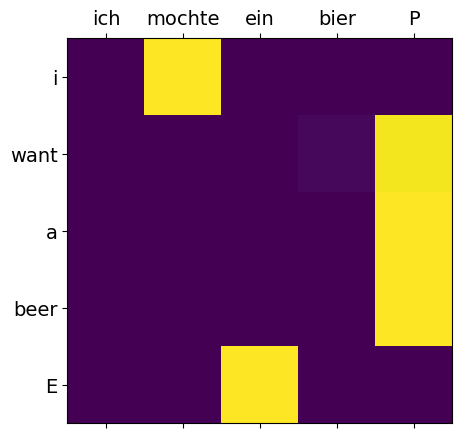

In [3]:
# Show Attention
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(trained_attn, cmap='viridis')
ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
plt.show()

-  특정 위치 (x, y)의 사각형 색이 밝을수록, 모델이 y축 단어를 생성할 때 x축 단어를 강하게 참고했다는 의미임

### Code Test

In [4]:
target_batch = [[word_dict[n] for n in sentences[2].split()]]
torch.LongTensor(target_batch).shape

torch.Size([1, 5])